In [1]:
# set up some environmental dependencies
import time, sys, os
import h5py
import numpy as np
from astropy.table import Table
import scipy
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy import coordinates
from astropy.table import Table
import astropy.cosmology.units as cu
import astropy.units as u
from matplotlib.pyplot import *
import seaborn as sns
import numpy as np, matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from astropy.io import ascii
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
import matplotlib
from astropy.table import Table
import warnings
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk') 
sns.set(font_scale=1.4)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']

cmap = matplotlib.cm.get_cmap('magma_r')
colors = ["white", "white", "white"]+[cmap(i/100) for i in range(100)]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                           colors)


In [2]:
# Reading in DSA data
dsa_frbs = read_dsa_data().reset_index()
dsa_radio_sheet = pd.read_excel('frbs_data/DSA110-FRBs.xlsx', 
                                sheet_name='frb_params', engine='openpyxl', 
                                keep_default_na=False, na_values='')
dsa_radio_sheet = dsa_radio_sheet.drop(0)

In [3]:
# Reading in galaxy number density function from Driver et al. (2016)
from astropy.io import fits
hdu_list = fits.open("galaxies_data/driver_et_al.fits", memmap=True)
data = Table(hdu_list[1].data).to_pandas()
data = data[np.logical_or(data['FilterName'] == 'r       ', data['FilterName'] == 'F606W   ')]
data = data.sort_values(by="MagBinCentre").reset_index()
data.head(2)

,index,Facility,FilterName,MagBinCentre,N(m),deltaN(m),SequenceNumber,CosmicVariance,Reference
0,272,SDSS,r,10.0,0.011181,0.007906,1,5,Wright et al. (2016)
1,273,SDSS,r,10.5,0.005590,0.005590,1,5,Wright et al. (2016)


(7.0, 32.0)

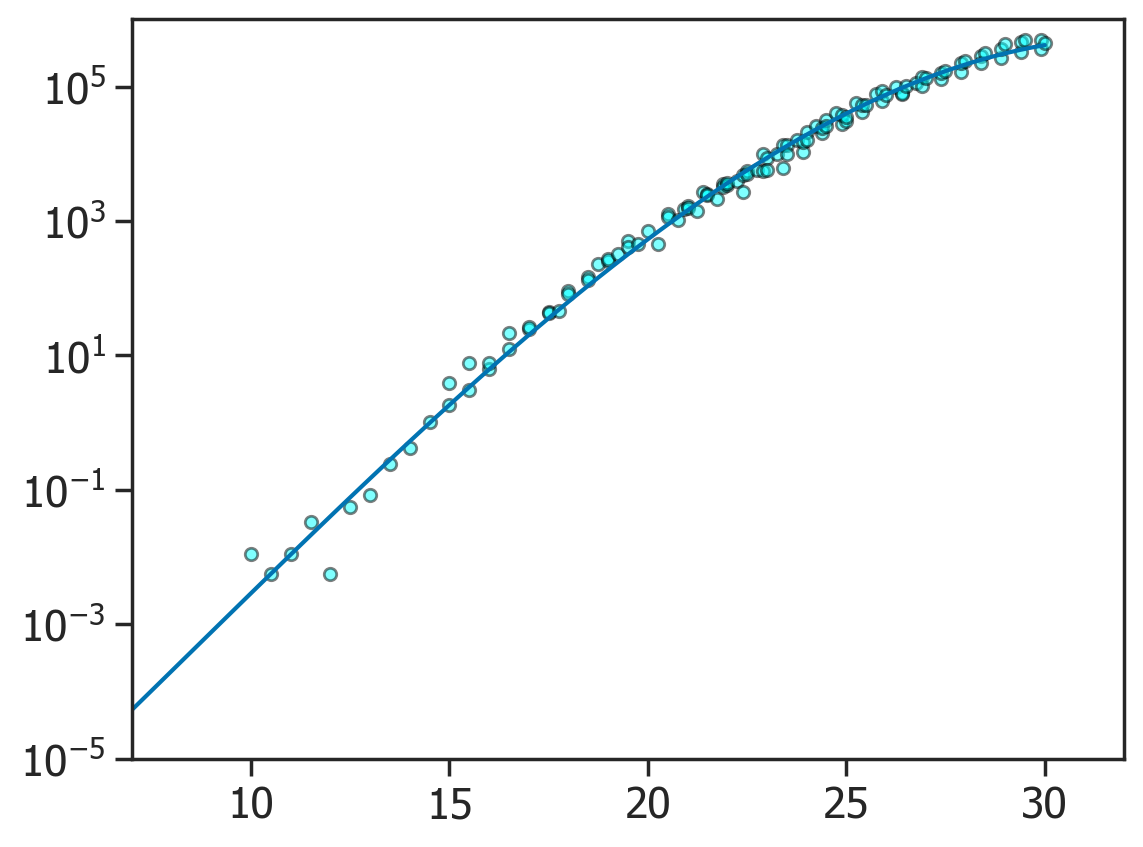

In [4]:
# Computing a spline fit to the galaxy number density as a function of magnitude - sigma(m) vs m
import scipy
from scipy.integrate import quad
from scipy.interpolate import splrep, BSpline

data_to_fit = data.drop_duplicates(subset='MagBinCentre')
tck = scipy.interpolate.splrep(data_to_fit['MagBinCentre'], 
                               np.log10(data_to_fit['N(m)']), s=len(data_to_fit)) # UnivariateSpline
mags = np.linspace(0, 30, 100)

def spline_function(x_val, tck=tck):
    """
    Evaluate the spline function at a given point.

    Parameters:
    - x_val: Input value or array where the spline should be evaluated
    - tck: Tuple (t,c,k) containing the vector of knots, the B-spline coefficients,
           and the degree of the spline

    Returns:
    - Value of the spline function evaluated at x_val
    """
    return 10 ** BSpline(*tck)(x_val)

plt.scatter(data['MagBinCentre'], data['N(m)'], s=20, color="cyan", edgecolor="black", alpha=0.5)
plt.plot(mags, spline_function(mags))
plt.yscale('log')
plt.ylim(1e-5, 1e6)
plt.xlim(7, 32)

In [5]:
# Computing sigma (<m) vs m for computing P_cc
def integral_spline(x_min, x_max, tck=tck):
    """
    Compute the definite integral of the spline function from x_min to x_max.

    Parameters:
    - x_min: Lower limit of integration
    - x_max: Upper limit of integration
    - tck: Tuple (t,c,k) containing the vector of knots, the B-spline coefficients,
           and the degree of the spline

    Returns:
    - The definite integral of the spline function over the interval [x_min, x_max]
    """
    integral, _ = quad(spline_function, x_min, x_max, args=(tck,))
    return integral

integral_result = []
for i in range(len(mags)):
    integral_result.append(integral_spline(min(mags), mags[i]))


In [6]:
# Storing localization uncertainty, galactocentric offsets, half-light radii, 
# magnitudes and redshifts of DSA FRBs to compute P_cc
ra_loc_errs = []
dec_loc_errs = []
ra_offsets = []
dec_offsets = []
half_light = []
seps = []
r_mags = []
redshifts = []

for frb in dsa_frbs["frb_name"]:
    df = dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()
    redshifts.append(df['redshift'][0])
    host_pos = SkyCoord(df["host_loc (hms, dms)"][0].split(", ")[0], 
                        df["host_loc (hms, dms)"][0].split(", ")[1], 
                        unit=(u.hourangle, u.deg), frame='icrs')
    
    frb_pos, e_ra, e_dec = get_ra_dec_errs(frb)
    ra_loc_errs.append(e_ra)
    dec_loc_errs.append(e_dec)
    
    ra_offset = frb_pos[0].spherical_offsets_to(host_pos)[0].arcsec
    dec_offset = frb_pos[0].spherical_offsets_to(host_pos)[1].arcsec
    ra_offsets.append(ra_offset)
    dec_offsets.append(dec_offset)
    
    half_light.append(df["half_light_radius (arcsec)"][0])
    r_mags.append(df["r_mag"][0])
    

In [7]:
# Computing P_cc of DSA FRBs
radii = []
areas = []
Pccs = []
for i in range(len(ra_loc_errs)):
    radii.append(max(2*np.sqrt(np.array(ra_loc_errs)[i]*np.array(dec_loc_errs)[i]), 
                     np.sqrt(np.array(ra_offsets)[i]**2 + np.array(dec_offsets)[i]**2 + 4*np.array(half_light)[i]**2)
                    )
                )
    area = np.pi*((radii[-1]/3600)**2)
    Pcc = 1-np.exp(-np.array(integral_result)*area)
    fxn = scipy.interpolate.interp1d(mags, Pcc, fill_value="extrapolate")
    Pccs.append(fxn(r_mags[i]))


In [8]:
# Computing P_cc for a grid of r-band magnitudes and radii
grid_size = 1000
rmag_grid = np.linspace(10, 30, grid_size)
radius_grid =  10**np.linspace(-1, 2, grid_size)

rmag_grid, radius_grid = np.meshgrid(rmag_grid, radius_grid)
Pcc_grid1 = np.zeros((grid_size, grid_size))

from tqdm import tqdm
for k in tqdm(range(grid_size)):
    for l in range(grid_size):
        area = np.pi*((radius_grid[k][l]/3600)**2)
        Pcc = 1-np.exp(-np.array(integral_result)*area)
        fxn = scipy.interpolate.interp1d(mags, Pcc, fill_value="extrapolate")
        Pcc_grid1[k][l] = fxn(rmag_grid[k][l])

100%|██████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.06it/s]


In [9]:
# Computing P_cc for a grid of r-band magnitudes and redshifts
r_freq = 3e10/481e-7 # Hz
rmag_grid = np.linspace(10, 30, grid_size)
z_grid =  10**np.linspace(-2, 1.5, grid_size)

rmag_grid, z_grid = np.meshgrid(rmag_grid, z_grid)
Pcc_grid = np.zeros((grid_size, grid_size))

# parameters in galaxy Mass-Radius relation from Van Der Wel et al. 2014
logA = 0.86
alpha = 0.25

from tqdm import tqdm
for k in tqdm(range(grid_size)):
    for l in range(grid_size):
        # converting magnitudes to stellar mass, assuming M/L = 1
        flux_nu_bins = (10**(rmag_grid[k][l]/-2.5)*3631/1e23)
        flux_bins = flux_nu_bins*r_freq
        mass = np.log10(flux_bins*(4*np.pi*(cosmo.luminosity_distance(z_grid[k][l]).to(u.cm).value**2))/3.846e33)
        
        # computing half-light radii using the galaxy Mass-Radius relation from Van Der Wel et al. 2014
        Reff = 10**(logA + alpha*(mass - np.log10(5e10))) # kpc
        Reff = (Reff*1e-3/cosmo.angular_diameter_distance(z_grid[k][l]).value)*u.radian.to(u.arcsec)

        # computing the P_cc
        area = np.pi*(8*(Reff/3600)**2)
        Pcc = 1-np.exp(-np.array(integral_result)*area)
        fxn = scipy.interpolate.interp1d(mags, Pcc, fill_value="extrapolate")
        Pcc_grid[k][l] = fxn(rmag_grid[k][l])
        

100%|██████████████████████████████████████████████████████████| 1000/1000 [03:16<00:00,  5.10it/s]


In [10]:
import matplotlib.colors as mcolors
levels = 10**np.linspace(-8, 1, 20)

cmap = matplotlib.cm.get_cmap('Spectral_r')
colors = [cmap(i/len(levels)) for i in range(len(levels))]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, cmap.N)

Text(0.8, 0.57, '$P_{cc} = 10^{-1}$')

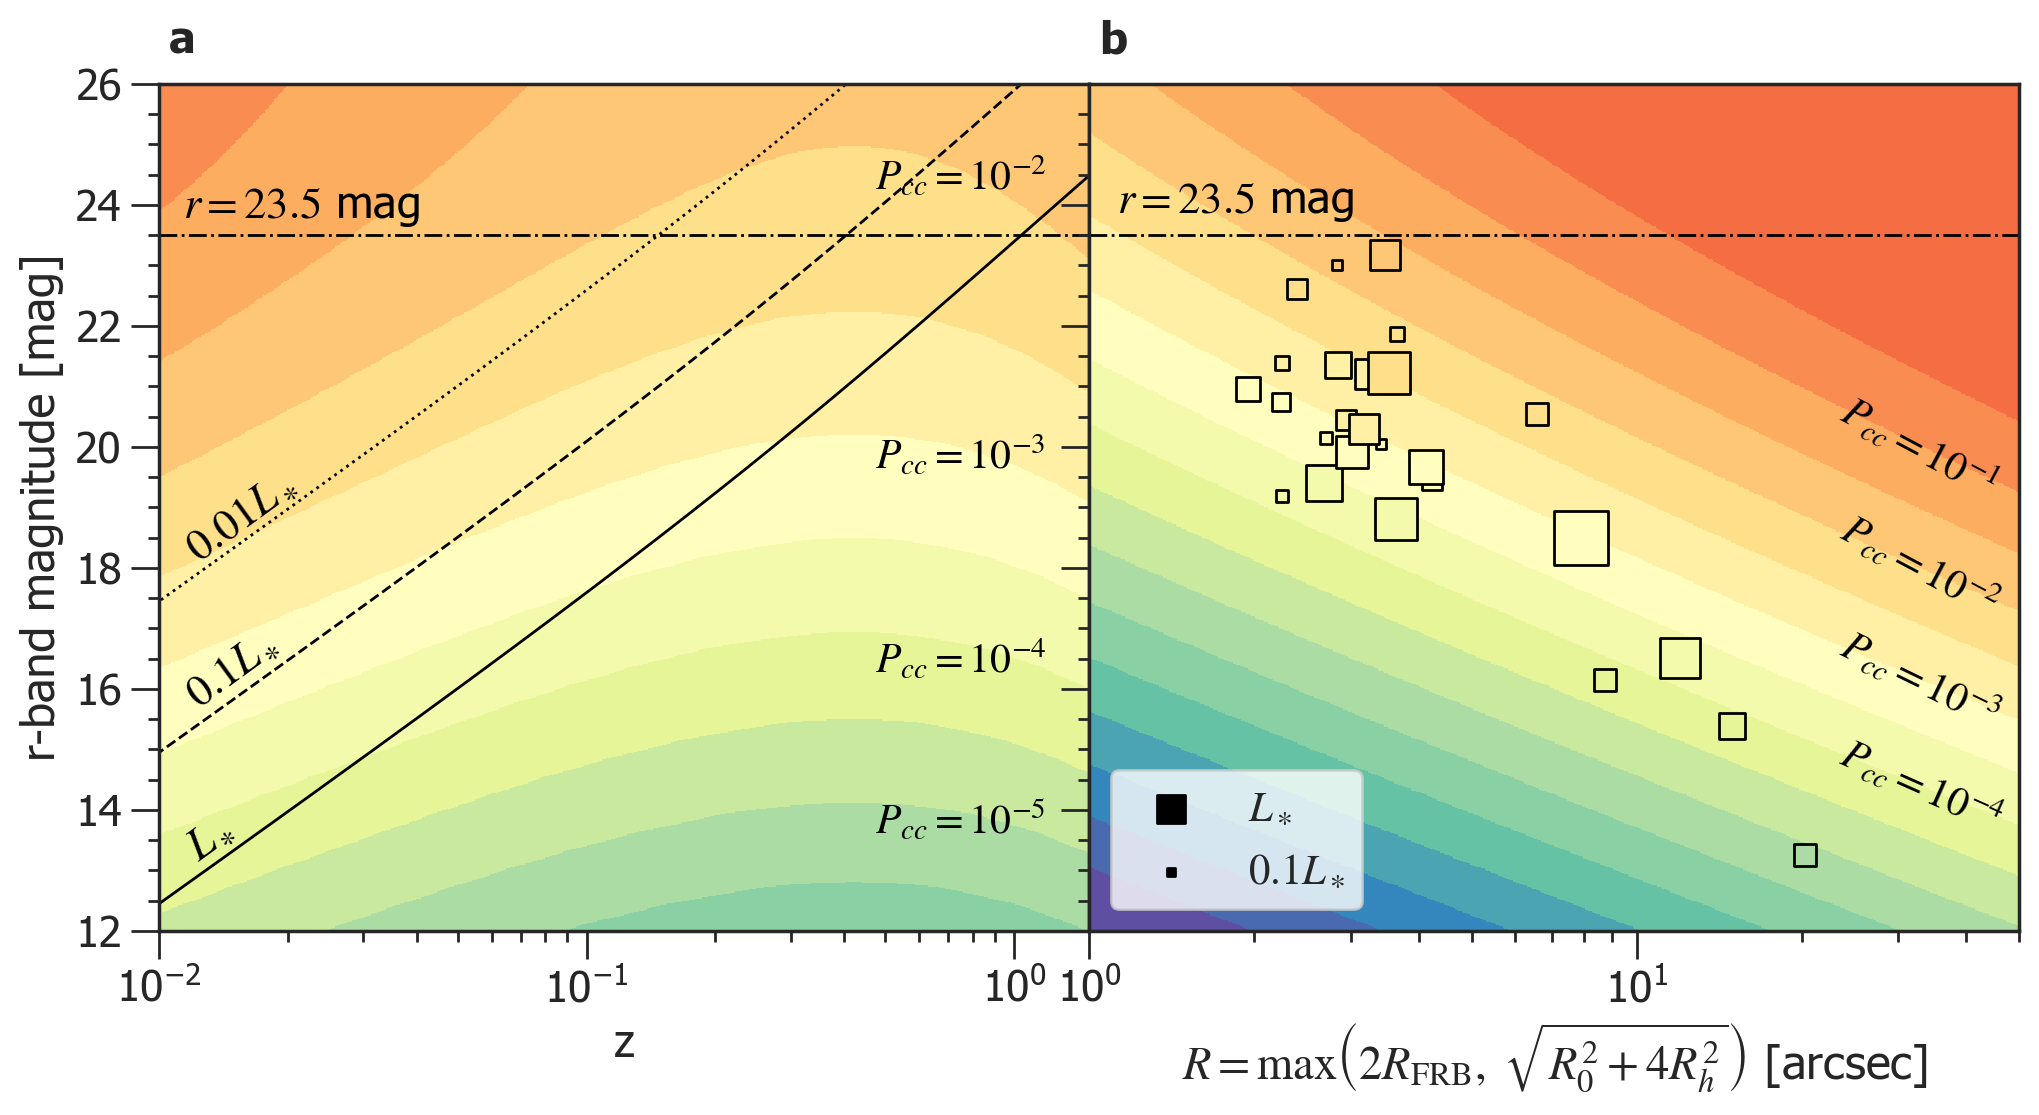

In [11]:
lsun = 3.846e33 # erg/s
lstar = 1.4e10*lsun
z_bins = np.linspace(1e-3, 1.5, 1000)
dist_bins = cosmo.luminosity_distance(z_bins).to(u.cm).value

fig, (ax2, ax1) = plt.subplots(1, 2, sharey=True, figsize=(12, 5.5))

pcolormesh = ax1.pcolormesh(radius_grid, rmag_grid, Pcc_grid1,
                            shading='auto', cmap=cmap, norm=norm)

pcolormesh = ax2.pcolormesh(z_grid, rmag_grid, Pcc_grid,
                            shading='auto', cmap=cmap, norm=norm)

ax1.axhline(23.5, ls="dashdot", color="black", lw=1)
ax1.text(.03, .86, r"$r=23.5$ mag", color="black", ha='left', va='center', 
             transform=ax1.transAxes, rotation = 0, fontsize=16)

lums = []
for i in range(len(dsa_frbs)):
    frb_name = dsa_frbs["frb_name"][i]
    df1 = dsa_frbs[dsa_frbs["frb_name"]==frb_name].reset_index()
    df2 = dsa_radio_sheet[dsa_radio_sheet["Nickname"]==frb_name].reset_index()
    if dsa_frbs["sed_done?"][i] == "Y" and dsa_frbs["sample"][i] == "Silver":
        lum = (10**(r_mags[i]/-2.5)*3631/1e23)*r_freq*(4*np.pi*(cosmo.luminosity_distance(dsa_frbs["redshift"][i]).to(u.cm).value**2))
        lums.append(lum/lstar)
        im = ax1.scatter([radii[i]], [r_mags[i]], c = [Pccs[i]], 
                         norm=norm, cmap=cmap, marker="s", s=100*(lum/lstar), edgecolors='black', alpha=1)
    else:
        lum = (10**(r_mags[i]/-2.5)*3631/1e23)*r_freq*(4*np.pi*(cosmo.luminosity_distance(dsa_frbs["redshift"][i]).to(u.cm).value**2))
        lums.append(lum/lstar)
        im = ax1.scatter([radii[i]], [r_mags[i]], c = [Pccs[i]], 
                         norm=norm, cmap=cmap, marker="s", s=100*(lum/lstar), edgecolors='black', alpha=1)


ax1.set_xscale('log')
ax1.set_xlim(1, 50)
ax1.set_yticks(np.arange(12, 26, 2)) 
ax1.set_ylim(12, 26)
ax1.yaxis.set_major_locator(MultipleLocator(2))                                                                                                                                                                                                                     
ax1.yaxis.set_minor_locator(MultipleLocator(0.5)) 
ax1.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax1.tick_params(which='both', width=1)
ax1.tick_params(which='major', length=10)
ax1.tick_params(which='minor', length=4)

ax1.set_xlabel(r"$R = \max \left(2R_{\mathrm{FRB}},~\sqrt{R_0^2 + 4R_h^2}\right)$ [arcsec]")
ax2.set_ylabel("r-band magnitude [mag]")

ax1.scatter([100], [100], c = "black", marker="s", s=100*1, edgecolors='black', alpha=1, label=r"$L_\ast$")
ax1.scatter([100], [100], c = "black", marker="s", s=100*0.1, edgecolors='black', alpha=1, label=r"$0.1L_\ast$")
ax1.legend(loc="lower left")


ax2.axhline(23.5, ls="dashdot", color="black", lw=1)
ax2.text(.025, .855, r"$r=23.5$ mag", color="black", ha='left', va='center', 
             transform=ax2.transAxes, rotation = 0, fontsize=16)

l = lstar
flux_bins = l/(4*np.pi*(dist_bins**2)) # erg/s/cm2
flux_nu_bins = flux_bins/r_freq
mags_ = -2.5*np.log10(flux_nu_bins*1e23/3631)
ax2.plot(z_bins, mags_, color="black", ls="solid", lw=1)

l = 0.1*lstar
flux_bins = l/(4*np.pi*(dist_bins**2)) # erg/s/cm2
flux_nu_bins = flux_bins/r_freq
mags_ = -2.5*np.log10(flux_nu_bins*1e23/3631)
ax2.plot(z_bins, mags_, color="black", ls="--", lw=1)

l = 0.01*lstar
flux_bins = l/(4*np.pi*(dist_bins**2)) # erg/s/cm2
flux_nu_bins = flux_bins/r_freq
mags_ = -2.5*np.log10(flux_nu_bins*1e23/3631)
ax2.plot(z_bins, mags_, color="black", ls="dotted", lw=1)


ax2.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax2.tick_params(which='both', width=1)
ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', length=4)
ax2.set_xlabel(r"z")
plt.subplots_adjust(wspace=0)


ax2.text(.02, .11, r"$L_\ast$", color="black", ha='left', va='center', 
             transform=ax2.transAxes, rotation = 36, fontsize=16)
ax2.text(.02, .31, r"$0.1 L_\ast$", color="black", ha='left', va='center', 
             transform=ax2.transAxes, rotation = 36, fontsize=16)
ax2.text(.02, .49, r"$0.01 L_\ast$", color="black", ha='left', va='center',
         transform=ax2.transAxes, rotation = 36, fontsize=16)

ax2.set_xscale('log')
ax2.set_xlim(1e-2, 1.5)

ax2.text(0.01, 1.05, "a", ha='left', va='center', weight='bold', 
         transform=ax2.transAxes, fontsize=16)
ax1.text(0.01, 1.05, "b", ha='left', va='center', weight='bold', 
         transform=ax1.transAxes, fontsize=16)


ax2.text(.77, .13, r"$P_{cc} = 10^{-5}$", color="black", ha='left', va='center', transform=ax2.transAxes, rotation=0, fontsize=15)
ax2.text(.77, .32, r"$P_{cc} = 10^{-4}$", color="black", ha='left', va='center', transform=ax2.transAxes, rotation=0, fontsize=15)
ax2.text(.77, .56, r"$P_{cc} = 10^{-3}$", color="black", ha='left', va='center', transform=ax2.transAxes, rotation=0, fontsize=15)
ax2.text(.77, .89, r"$P_{cc} = 10^{-2}$", color="black", ha='left', va='center', transform=ax2.transAxes, rotation=0, fontsize=15)


ax1.text(.8, .17, r"$P_{cc} = 10^{-4}$", color="black", ha='left', va='center', transform=ax1.transAxes, rotation=-24, fontsize=15)
ax1.text(.8, .295, r"$P_{cc} = 10^{-3}$", color="black", ha='left', va='center', transform=ax1.transAxes, rotation=-26, fontsize=15)
ax1.text(.8, .43, r"$P_{cc} = 10^{-2}$", color="black", ha='left', va='center', transform=ax1.transAxes, rotation=-28, fontsize=15)
ax1.text(.8, .57, r"$P_{cc} = 10^{-1}$", color="black", ha='left', va='center', transform=ax1.transAxes, rotation=-28, fontsize=15)

